# Calculate titers of spike-pseudotyped lentiviruses on different cell lines

In [1]:
import os
import warnings

import math
import numpy as np 

from IPython.display import display, HTML
import matplotlib.pyplot as plt

from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import pandas as pd
from plotnine import *

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config


In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed

In [4]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

In [5]:
titers = pd.read_csv(config['virus_titers'])

titers = (titers
          .assign(RLUperuL=lambda x: x['RLU_per_well'] / x['uL_virus'],
                  date=lambda x: x['date'].astype(str)
                 )
         )

display(HTML(titers.head().to_html(index=False)))

plasmid,replicate,virus,dilution,uL_virus,RLU_per_well,date,cells,RLUperuL
2800,rep1,Wuhan1_614G,0.250000,25.0000,4085192,241021,293T_consensus_kozak,163407.68
2800,rep1,Wuhan1_614G,0.125000,12.5000,613486,241021,293T_consensus_kozak,49078.88
2800,rep1,Wuhan1_614G,0.062500,6.2500,128746,241021,293T_consensus_kozak,20599.36
2800,rep1,Wuhan1_614G,0.031250,3.1250,45646,241021,293T_consensus_kozak,14606.72
2800,rep1,Wuhan1_614G,0.015625,1.5625,24070,241021,293T_consensus_kozak,15404.80


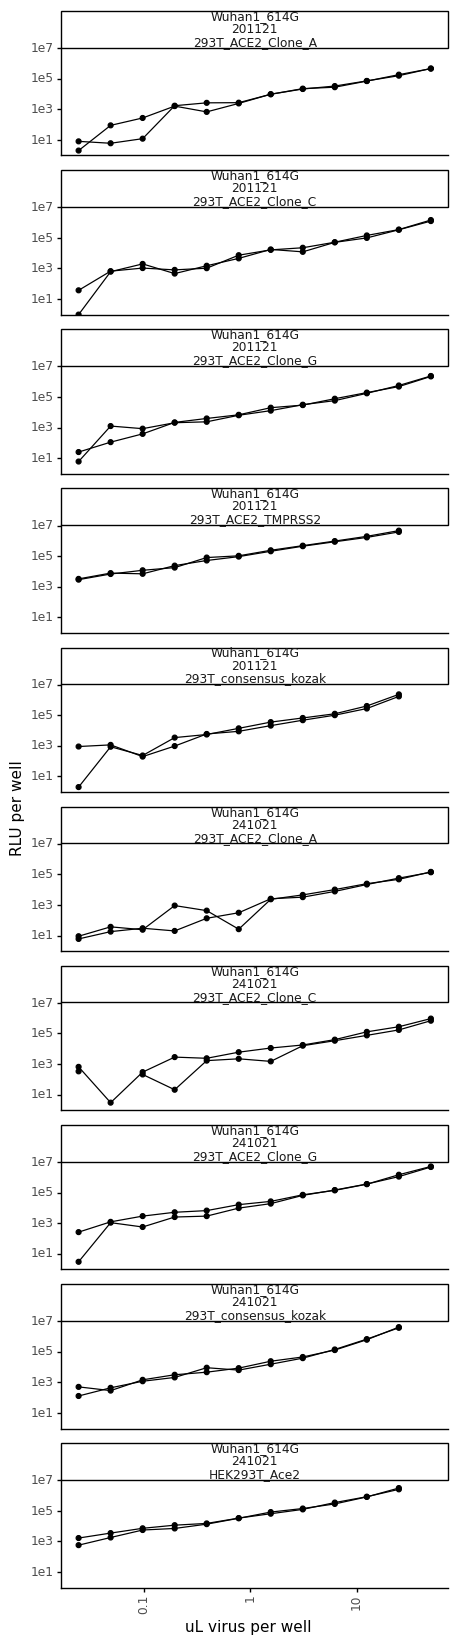

In [6]:
ncol=min(8, titers['virus'].nunique())
nrow=math.ceil(titers['virus'].nunique() / ncol)

p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLU_per_well', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date+cells', ncol=ncol) +
     scale_y_log10(name='RLU per well') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(5 * ncol, 20 * nrow),
           )
     )

_ = p.draw()

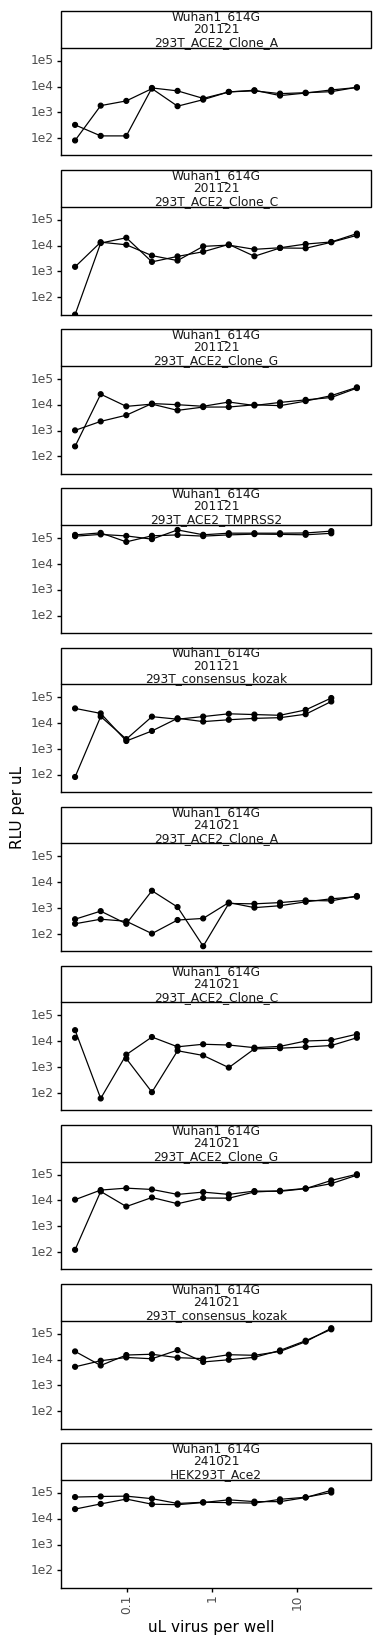

In [7]:
p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLUperuL', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date+cells', ncol=ncol) +
     scale_y_log10(name='RLU per uL') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(4 * ncol, 20 * nrow),
           ) 
     )

_ = p.draw()

From visual inspection of the above plots, it appears that only the 5 highest dilutions (i.e., >1uL of virus per well) are reliable enough to calculate titers. 

In [8]:
average_titers = (titers
                  .dropna() # missing values for some replicates
                  .query('uL_virus > 1') # drop lowest concentration of virus
                  .groupby(['virus', 'replicate', 'date', 'cells'])
                  .agg(mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean))
                  .reset_index()
                 )

display(HTML(average_titers.head().to_html(index=False)))

virus,replicate,date,cells,mean_RLUperuL
Wuhan1_614G,rep1,201121,293T_ACE2_Clone_A,6617.546667
Wuhan1_614G,rep1,201121,293T_ACE2_Clone_C,13435.146667
Wuhan1_614G,rep1,201121,293T_ACE2_Clone_G,18858.410000
Wuhan1_614G,rep1,201121,293T_ACE2_TMPRSS2,160942.064000
Wuhan1_614G,rep1,201121,293T_consensus_kozak,37778.880000


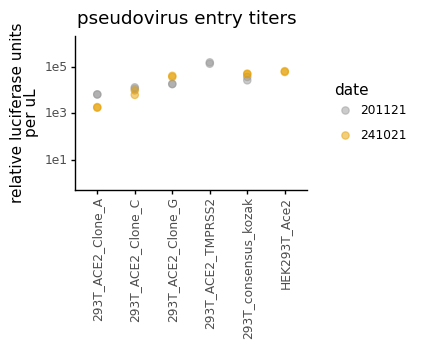

In [9]:
p = (ggplot(average_titers, 
            aes(x='cells', y='mean_RLUperuL', color='date')
           ) +
     geom_point(size=2.5, alpha=0.5)+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(average_titers['virus'].nunique()*3,2),
           axis_title_x=element_blank(),
          ) +
     scale_y_log10(limits=[1,1.1e6]) +
     ylab('relative luciferase units\nper uL')+
     labs(title='pseudovirus entry titers') +
     scale_color_manual(values=CBPALETTE)
    )

_ = p.draw()

Calculate how much virus to use in neut assays:

In [10]:
target_RLU = 2e5
uL_virus_per_well = 50

dilute_virus = (average_titers
                .groupby(['virus', 'date', 'cells'])
                .agg(RLUperuL=pd.NamedAgg(column='mean_RLUperuL', aggfunc=np.mean))
                .reset_index()
                .assign(target_RLU = target_RLU,
                        uL_virus_per_well = uL_virus_per_well,
                        dilution_factor = lambda x: x['RLUperuL']/target_RLU*uL_virus_per_well,
                        uL_per_8mL = lambda x: 8000/x['dilution_factor'],
                        media_for_8ml = lambda x: 8000 - 8000/x['dilution_factor']
                       )
               )


titerfile = os.path.join(resultsdir, 'virus_titers.csv')
print(f"Saving to {titerfile}")

dilute_virus.to_csv(titerfile, index=False)

display(HTML(dilute_virus.to_html(index=False)))

Saving to results/virus_titers.csv


virus,date,cells,RLUperuL,target_RLU,uL_virus_per_well,dilution_factor,uL_per_8mL,media_for_8ml
Wuhan1_614G,201121,293T_ACE2_Clone_A,6633.666667,200000.0,50,1.658417,4823.878197,3176.121803
Wuhan1_614G,201121,293T_ACE2_Clone_C,12514.403333,200000.0,50,3.128601,2557.053592,5442.946408
Wuhan1_614G,201121,293T_ACE2_Clone_G,18691.020000,200000.0,50,4.672755,1712.052098,6287.947902
Wuhan1_614G,201121,293T_ACE2_TMPRSS2,150397.364000,200000.0,50,37.599341,212.769687,7787.230313
Wuhan1_614G,201121,293T_consensus_kozak,32359.316000,200000.0,50,8.089829,988.896057,7011.103943
Wuhan1_614G,241021,293T_ACE2_Clone_A,1830.921667,200000.0,50,0.457730,17477.536359,-9477.536359
Wuhan1_614G,241021,293T_ACE2_Clone_C,8123.145000,200000.0,50,2.030786,3939.360925,4060.639075
Wuhan1_614G,241021,293T_ACE2_Clone_G,39923.311667,200000.0,50,9.980828,801.536713,7198.463287
Wuhan1_614G,241021,293T_consensus_kozak,50877.348000,200000.0,50,12.719337,628.963601,7371.036399
Wuhan1_614G,241021,HEK293T_Ace2,64376.044000,200000.0,50,16.094011,497.079317,7502.920683


In [11]:
# !jupyter nbconvert calculate_titer.ipynb --to HTML